In [1]:
import os
import shutil
from pathlib import Path

import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow import keras
from tqdm import tqdm

## Prepare data

In [2]:
DATA_URL = "http://download.tensorflow.org/example_images/flower_photos.tgz"
VAL_SIZE = 500
TRAIN_DIR = './train'
VAL_DIR = './val'

In [3]:
shutil.rmtree(TRAIN_DIR, ignore_errors=True)
shutil.rmtree(VAL_DIR, ignore_errors=True)

In [4]:
data_dir = keras.utils.get_file(
    os.path.basename(DATA_URL),
    DATA_URL,
    cache_dir='./',
    cache_subdir='',
    extract=True
)
data_dir = os.path.splitext(data_dir)[0]

In [5]:
files = []
for path in Path(data_dir).rglob('*.jpg'):
    files.append({'filename': path.name, 'class': path.parent.name, 'path': str(path)})
df_data = pd.DataFrame(files)

print(f"loaded {len(df_data)} files")
df_data.head()

loaded 3670 files


,filename,class,path
0,100080576_f52e8ee070_n.jpg,daisy,flower_photos\daisy\100080576_f52e8ee070_n.jpg
1,10140303196_b88d3d6cec.jpg,daisy,flower_photos\daisy\10140303196_b88d3d6cec.jpg
2,10172379554_b296050f82_n.jpg,daisy,flower_photos\daisy\10172379554_b296050f82_n.jpg
3,10172567486_2748826a8b.jpg,daisy,flower_photos\daisy\10172567486_2748826a8b.jpg
4,10172636503_21bededa75_n.jpg,daisy,flower_photos\daisy\10172636503_21bededa75_n.jpg


In [6]:
split = StratifiedShuffleSplit(n_splits=1, test_size=VAL_SIZE, random_state=42)
df_train, df_val = None, None
for train_idx, test_idx in split.split(df_data, df_data['class']):
    df_train = df_data.loc[train_idx]
    df_val = df_data.loc[test_idx]

print(f"len(df_train) = {len(df_train)}, len(df_val) = {len(df_val)}")

len(df_train) = 3170, len(df_val) = 500


In [7]:
def copy_images(df, base_dir):
    if not os.path.exists(base_dir):
        os.mkdir(base_dir)
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        class_name = row['class']
        src_path = row['path']
        category_path = os.path.join(base_dir, class_name)
        if not os.path.exists(category_path):
            os.mkdir(category_path)
        dst_path = os.path.join(category_path, os.path.basename(src_path))
        shutil.copyfile(src_path, dst_path)

In [8]:
copy_images(df_train, TRAIN_DIR)
copy_images(df_val, VAL_DIR)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 175.39it/s]


## Load data

In [9]:
TRAIN_DIR = './train'
VAL_DIR = './val'
INPUT_SIZE = 224
BATCH_SIZE = 32

In [10]:
def preprocess_input(image):
    image /= 255
    return image

In [11]:
train_generator = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data = train_generator.flow_from_directory(
    TRAIN_DIR, 
    target_size=(INPUT_SIZE, INPUT_SIZE), 
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical'
)

val_generator = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_data = val_generator.flow_from_directory(
    VAL_DIR,
    target_size=(INPUT_SIZE, INPUT_SIZE), 
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical'
)

Found 3170 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [12]:
num_classes = train_data.num_classes
class_names = list(map(lambda p: p[0], sorted(train_data.class_indices.items(), key=lambda p: p[1])))
print(f"num_classes = {num_classes}, class_names = {class_names}")

num_classes = 5, class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Show data

In [13]:
import utils

x_batch.shape = (32, 224, 224, 3)
y_batch.shape = (32, 5)


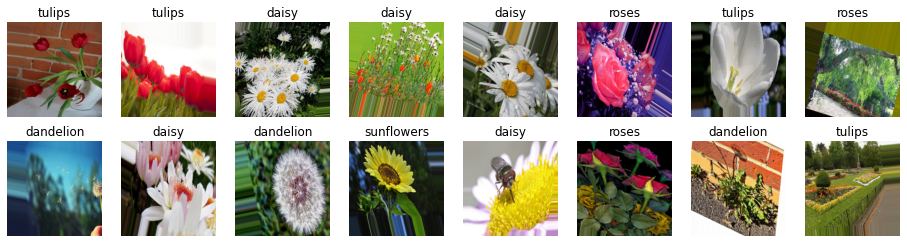

In [14]:
for x_batch, y_batch in train_data:
    print(f"x_batch.shape = {x_batch.shape}")
    print(f"y_batch.shape = {y_batch.shape}")
    break

utils.plot_images(x_batch[:16], y_batch[:16], class_names=class_names)

x_batch.shape = (32, 224, 224, 3)
y_batch.shape = (32, 5)


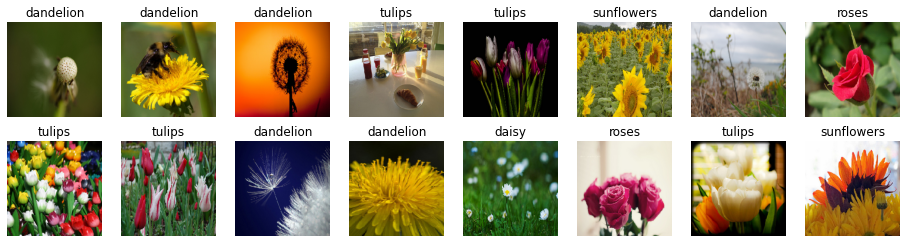

In [15]:
for x_batch, y_batch in val_data:
    print(f"x_batch.shape = {x_batch.shape}")
    print(f"y_batch.shape = {y_batch.shape}")
    break

utils.plot_images(x_batch[:16], y_batch[:16], class_names=class_names)